In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from sklearn.metrics import jaccard_score
from itertools import combinations
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset
file_path = 'Data/Analyst_Coverage.csv'
df = pd.read_csv(file_path)

Course project 3

○ Building an unsupervised model to cluster stocks, modeling covariance/distance matrix structures

○ Understanding how companies/stocks are grouped together and investigate better ways of recategorizing peer groups

GICS industry code (8 digits) consists of:

11 sectors, 24 industry groups, 69 industries and 158 sub-industries

(sector | industry group | industry | sub-industry)

## Data Preprocessing

In [4]:
# Examine the structure and summary
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8676 entries, 0 to 8675
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ANALYST                   8676 non-null   object 
 1   DATE                      8676 non-null   object 
 2   BROKER                    8676 non-null   object 
 3   RATING                    8437 non-null   float64
 4   RECOMMENDATION            8676 non-null   object 
 5   TARGET_PRICE              8676 non-null   float64
 6   BBTICKER                  8676 non-null   object 
 7   GICS_SECTOR_NAME          8676 non-null   object 
 8   GICS_INDUSTRY_GROUP_NAME  8676 non-null   object 
dtypes: float64(2), object(7)
memory usage: 610.2+ KB
None


In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 ANALYST                       0
DATE                          0
BROKER                        0
RATING                      239
RECOMMENDATION                0
TARGET_PRICE                  0
BBTICKER                      0
GICS_SECTOR_NAME              0
GICS_INDUSTRY_GROUP_NAME      0
dtype: int64


In [6]:
# Drop rows with missing data (Assuming missing RATING means not properly covered by analyst)
df = df.dropna()
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 ANALYST                     0
DATE                        0
BROKER                      0
RATING                      0
RECOMMENDATION              0
TARGET_PRICE                0
BBTICKER                    0
GICS_SECTOR_NAME            0
GICS_INDUSTRY_GROUP_NAME    0
dtype: int64


In [7]:
# Check for duplicates
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)

Number of duplicate rows: 0


In [8]:
# Re-examine the structure and summary
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 8437 entries, 0 to 8675
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ANALYST                   8437 non-null   object 
 1   DATE                      8437 non-null   object 
 2   BROKER                    8437 non-null   object 
 3   RATING                    8437 non-null   float64
 4   RECOMMENDATION            8437 non-null   object 
 5   TARGET_PRICE              8437 non-null   float64
 6   BBTICKER                  8437 non-null   object 
 7   GICS_SECTOR_NAME          8437 non-null   object 
 8   GICS_INDUSTRY_GROUP_NAME  8437 non-null   object 
dtypes: float64(2), object(7)
memory usage: 659.1+ KB
None


## 1. Which company has the higher analyst coverage?

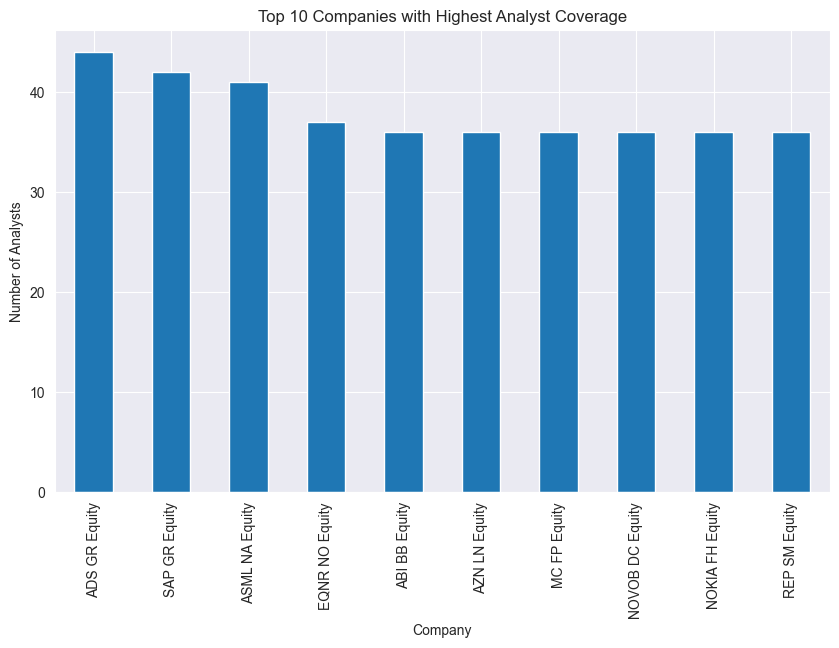

The company with the highest analyst coverage is 'ADS GR Equity' with 44 analysts covering it.


In [9]:
# Calculate the analyst coverage for each company
company_coverage = df['BBTICKER'].value_counts()

# Plot the top 10 companies with the highest analyst coverage
top_10_company_coverage = company_coverage.head(10)

plt.figure(figsize=(10, 6))
top_10_company_coverage.plot(kind='bar')
plt.title('Top 10 Companies with Highest Analyst Coverage')
plt.xlabel('Company')
plt.ylabel('Number of Analysts')
plt.show()

# Find the company with the highest analyst coverage
most_covered_company = company_coverage.idxmax()
most_covered_company_coverage = company_coverage.max()

print(f"The company with the highest analyst coverage is '{most_covered_company}' with {most_covered_company_coverage} analysts covering it.")


## 2. Which analyst covers the most companies?

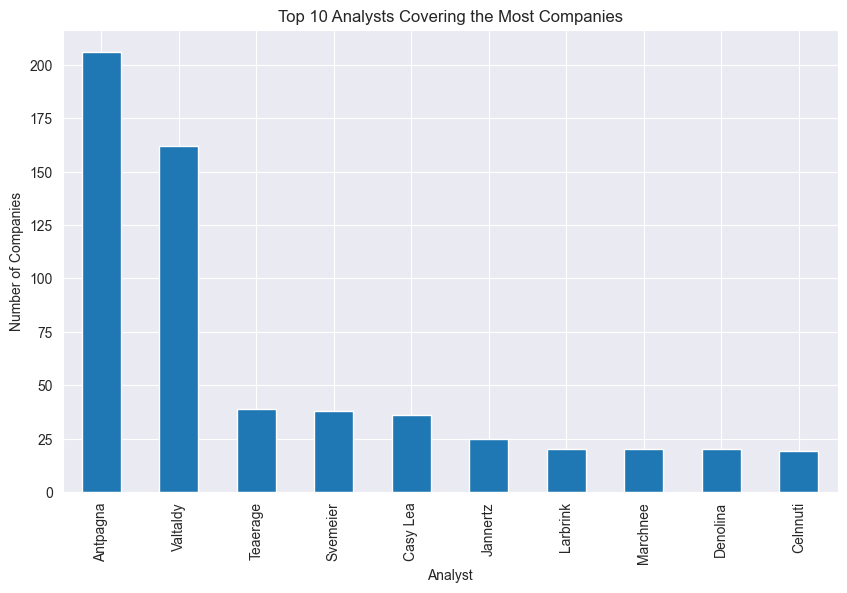

The analyst who covers the most companies is 'Antpagna' covering 206 different companies.


In [23]:
# Calculate the number of companies each analyst covers
analyst_coverage = df.groupby('ANALYST')['BBTICKER'].nunique()

# Plot the top 10 analysts covering the most companies
top_10_analyst_coverage = analyst_coverage.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_10_analyst_coverage.plot(kind='bar')

plt.title('Top 10 Analysts Covering the Most Companies')
plt.xlabel('Analyst')
plt.ylabel('Number of Companies')
plt.show()

# Find the analyst covering the most companies
most_companies_analyst = analyst_coverage.idxmax()
most_companies_coverage = analyst_coverage.max()

print(f"The analyst who covers the most companies is '{most_companies_analyst}' covering {most_companies_coverage} different companies.")


Shape of the similarity matrix: (360, 360)


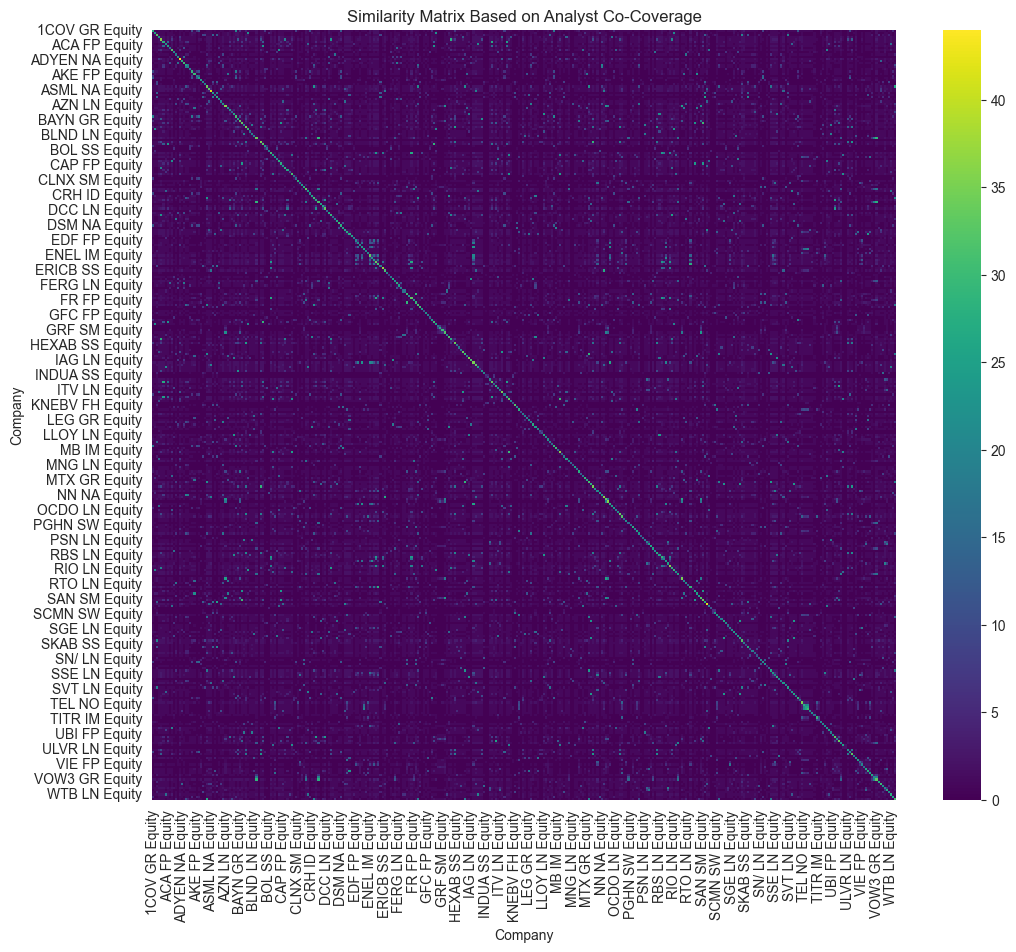

In [11]:
# Create a pivot table where rows are analysts and columns are companies
pivot_table = df.pivot_table(index='ANALYST', columns='BBTICKER', aggfunc='size', fill_value=0)

# Compute the similarity matrix (dot product of pivot table with its transpose)
similarity_matrix = np.dot(pivot_table.T, pivot_table)

# Convert to DataFrame for better visualization
similarity_df = pd.DataFrame(similarity_matrix, index=pivot_table.columns, columns=pivot_table.columns)

# Print the shape of the similarity matrix
print("Shape of the similarity matrix:", similarity_df.shape)

# Plot the similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_df, cmap='viridis')
plt.title('Similarity Matrix Based on Analyst Co-Coverage')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()


Shape of the filtered similarity matrix: (360, 360)


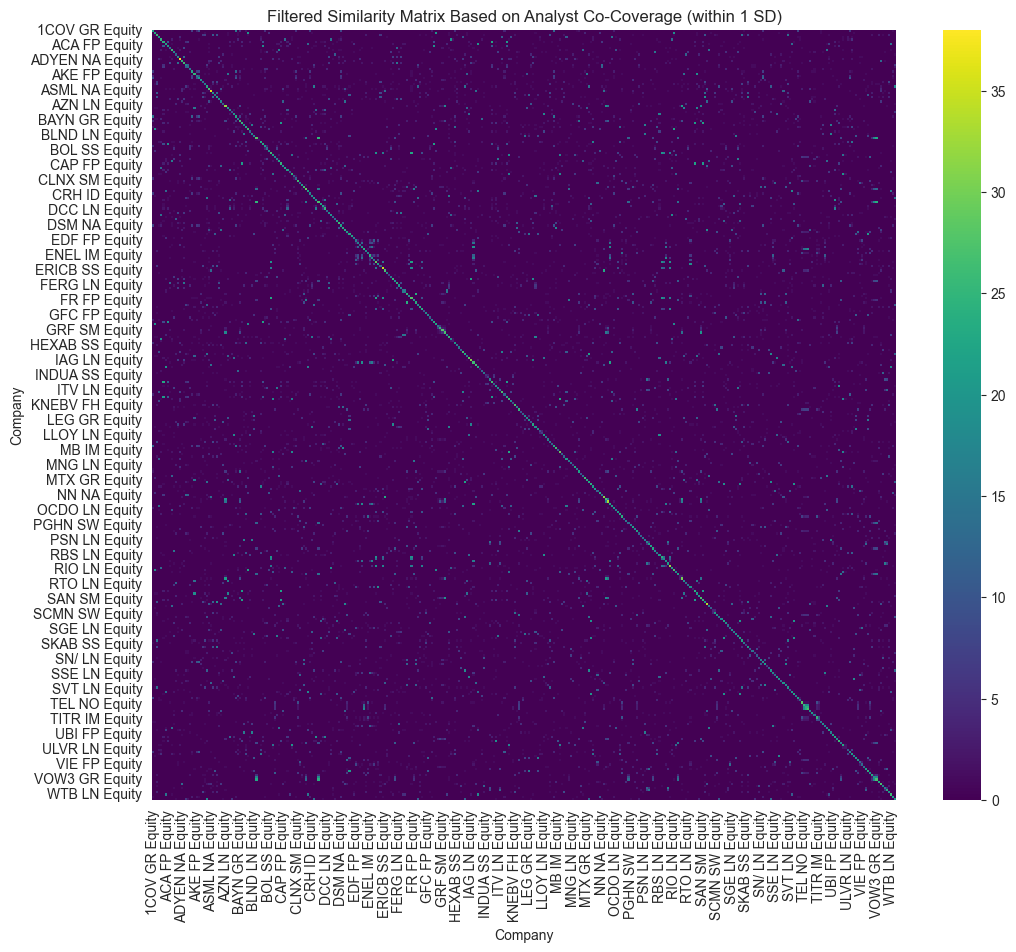

In [12]:
# Calculate the mean and standard deviation of the number of companies covered by each analyst
mean_coverage = analyst_coverage.mean()
std_dev_coverage = analyst_coverage.std()

# Filter analysts who cover companies within 1 standard deviation of the mean
filtered_analysts = analyst_coverage[(analyst_coverage >= mean_coverage - std_dev_coverage) & 
                                     (analyst_coverage <= mean_coverage + std_dev_coverage)].index

# Filter the dataframe to only include the filtered analysts
filtered_df = df[df['ANALYST'].isin(filtered_analysts)]

# Create a pivot table for the filtered analysts
filtered_pivot_table = filtered_df.pivot_table(index='ANALYST', columns='BBTICKER', aggfunc='size', fill_value=0)

# Compute the similarity matrix for the filtered data
filtered_similarity_matrix = np.dot(filtered_pivot_table.T, filtered_pivot_table)

# Convert to DataFrame for better visualization
filtered_similarity_df = pd.DataFrame(filtered_similarity_matrix, index=filtered_pivot_table.columns, columns=filtered_pivot_table.columns)

# Print the shape of the filtered similarity matrix
print("Shape of the filtered similarity matrix:", filtered_similarity_df.shape)

# Plot the filtered similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_similarity_df, cmap='viridis')
plt.title('Filtered Similarity Matrix Based on Analyst Co-Coverage (within 1 SD)')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()


Shape of the selected similarity matrix: (18, 18)


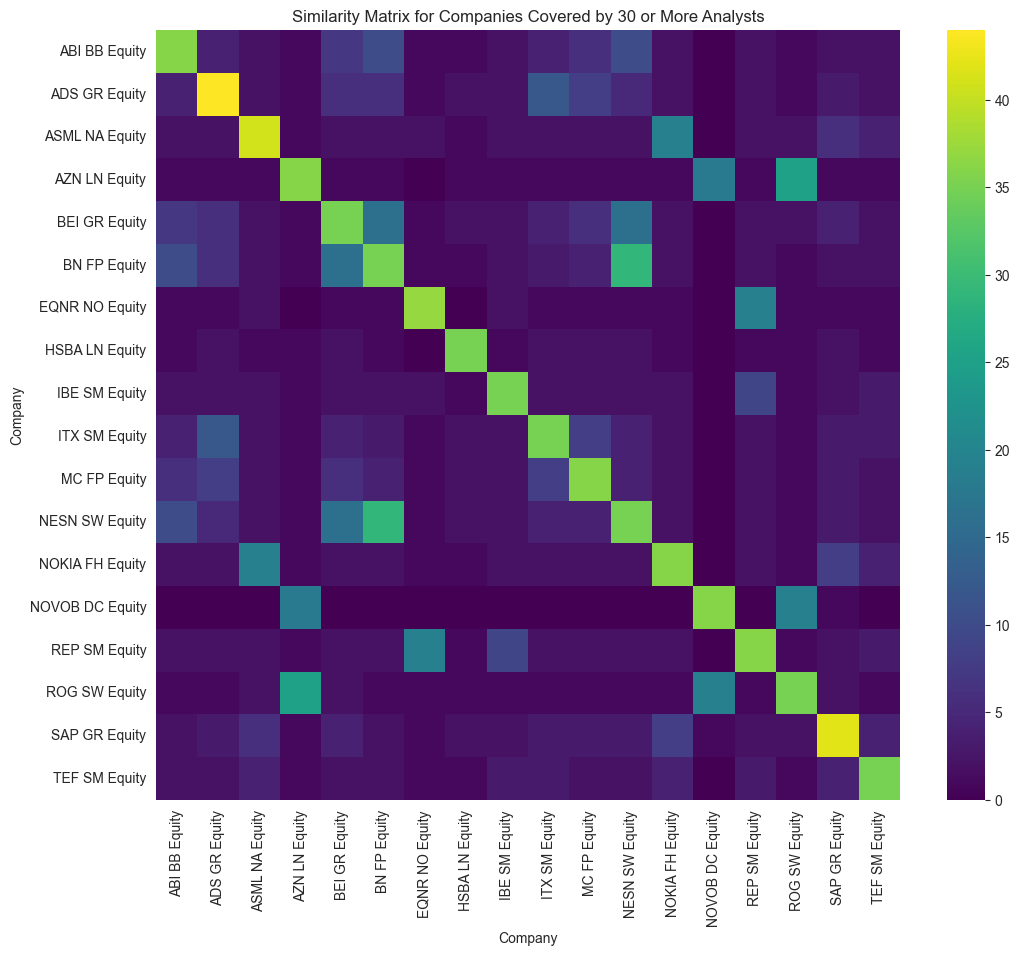

In [13]:
# Filter companies covered by 35 or more analysts
company_coverage = df['BBTICKER'].value_counts()
selected_companies = company_coverage[company_coverage >= 35].index

# Filter the dataframe to only include the selected companies
selected_df = df[df['BBTICKER'].isin(selected_companies)]

# Create a pivot table for the selected companies
selected_pivot_table = selected_df.pivot_table(index='ANALYST', columns='BBTICKER', aggfunc='size', fill_value=0)

# Compute the similarity matrix for the selected companies
selected_similarity_matrix = np.dot(selected_pivot_table.T, selected_pivot_table)

# Convert to DataFrame for better visualization
selected_similarity_df = pd.DataFrame(selected_similarity_matrix, index=selected_pivot_table.columns, columns=selected_pivot_table.columns)

# Print the shape of the selected similarity matrix
print("Shape of the selected similarity matrix:", selected_similarity_df.shape)

# Plot the selected similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(selected_similarity_df, cmap='viridis')
plt.title('Similarity Matrix for Companies Covered by 30 or More Analysts')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()
